### Data

In [7]:
# data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import altair as alt
import plotly.graph_objects as go
import geopandas as gpd
from sklearn.preprocessing import StandardScaler


data = pd.read_csv('climate_change_impact_on_agriculture_2024.csv')

data.head()

,Year,Country,Region,Crop_Type,Average_Temperature_C,Total_Precipitation_mm,CO2_Emissions_MT,Crop_Yield_MT_per_HA,Extreme_Weather_Events,Irrigation_Access_%,Pesticide_Use_KG_per_HA,Fertilizer_Use_KG_per_HA,Soil_Health_Index,Adaptation_Strategies,Economic_Impact_Million_USD
0,2001,India,West Bengal,Corn,1.55,447.06,15.22,1.737,8,14.54,10.08,14.78,83.25,Water Management,808.13
1,2024,China,North,Corn,3.23,2913.57,29.82,1.737,8,11.05,33.06,23.25,54.02,Crop Rotation,616.22
2,2001,France,Ile-de-France,Wheat,21.11,1301.74,25.75,1.719,5,84.42,27.41,65.53,67.78,Water Management,796.96
3,2001,Canada,Prairies,Coffee,27.85,1154.36,13.91,3.890,5,94.06,14.38,87.58,91.39,No Adaptation,790.32
4,1998,India,Tamil Nadu,Sugarcane,2.19,1627.48,11.81,1.080,9,95.75,44.35,88.08,49.61,Crop Rotation,401.72


### Initially looking at how crop yield has changed overtime across the world - it varies

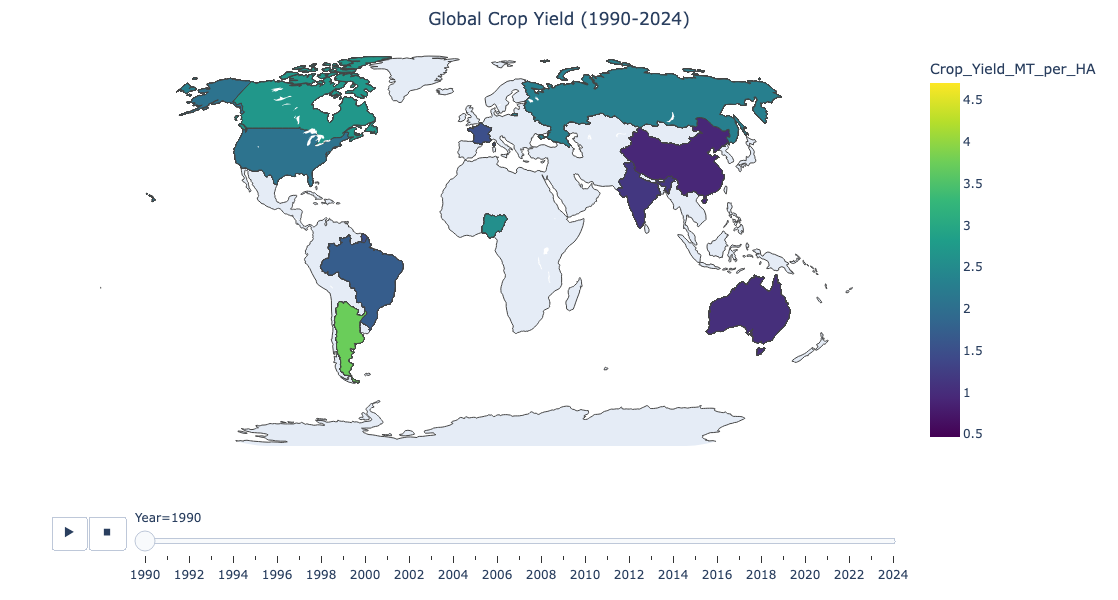

In [3]:
# Convert 'Year' column to integer and sort chronologically
data['Year'] = data['Year'].astype(int)
data = data.sort_values(by='Year')

# Convert 'Year' to string for the animation frame
data['Year'] = data['Year'].astype(str)

# Calculate min and max crop yields per year for dynamic color range
min_max_yields = data.groupby('Year')['Crop_Yield_MT_per_HA'].agg(['min', 'max']).to_dict('index')

# Function to set dynamic color range for each year
def get_color_range(year):
    return [min_max_yields[year]['min'], min_max_yields[year]['max']]

# Create the choropleth map for crop yield
fig = px.choropleth(
    data,
    locations="Country",
    locationmode="country names",
    color="Crop_Yield_MT_per_HA",
    hover_name="Country",
    animation_frame="Year",
    title="Global Crop Yield (1990-2024)",
    color_continuous_scale="Viridis"
)

# Adjust color scale dynamically for each frame
for frame in fig.frames:
    year = frame.name
    color_range = get_color_range(year)
    for data_trace in frame.data:
        data_trace.update(zmin=color_range[0], zmax=color_range[1])

# Layout
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type="natural earth"
    ),
    title_x=0.5,
    width=1000,
    height=600,
    legend_title="Crop Yield (MT per HA)",
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.show()


### Looking at if temperature affects this and there seems to be ideal temperature around 10-20 degrees celcius

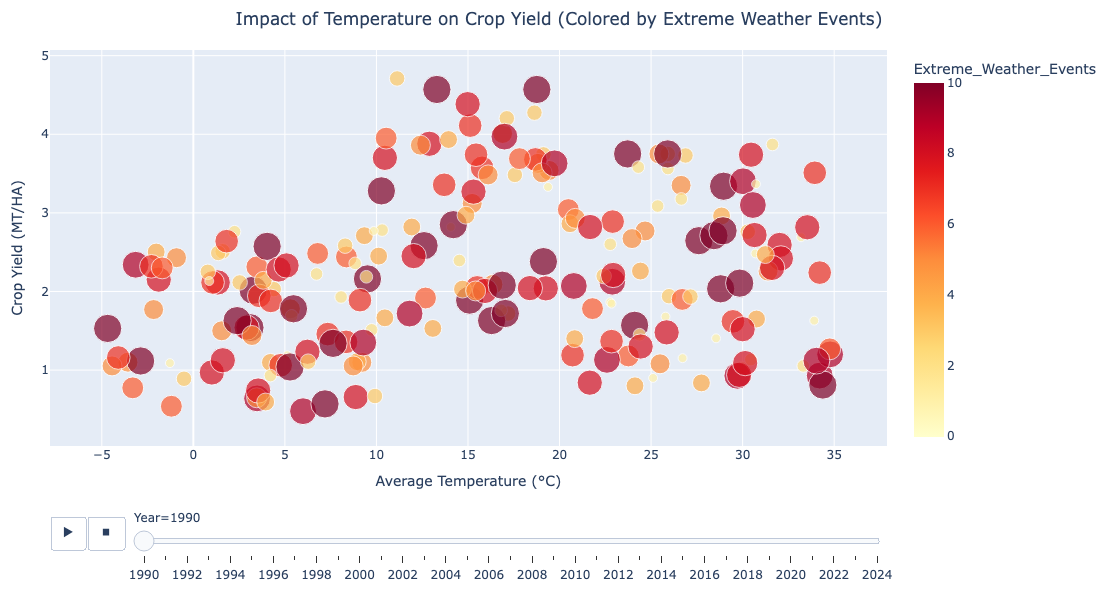

In [4]:
fig = px.scatter(
    data,
    x="Average_Temperature_C",
    y="Crop_Yield_MT_per_HA",
    color="Extreme_Weather_Events",
    size="Extreme_Weather_Events",
    hover_name="Country",
    animation_frame="Year",
    title="Impact of Temperature on Crop Yield (Colored by Extreme Weather Events)",
    color_continuous_scale="YlOrRd",
    labels={
        "Average_Temperature_C": "Average Temperature (°C)",
        "Crop_Yield_MT_per_HA": "Crop Yield (MT/HA)"
    }
)

fig.update_layout(
    width=900,
    height=600,
    title_x=0.5,
    margin=dict(l=50, r=50, t=50, b=50)
)
fig.show()


### 3 visualizations below where we try to analyze what drives highest and lowest crop yield while acknowledging the difference is pretty small

#### [place holder - add in kerissa's plot showing best and worst crop yield (nigeria and russia)]

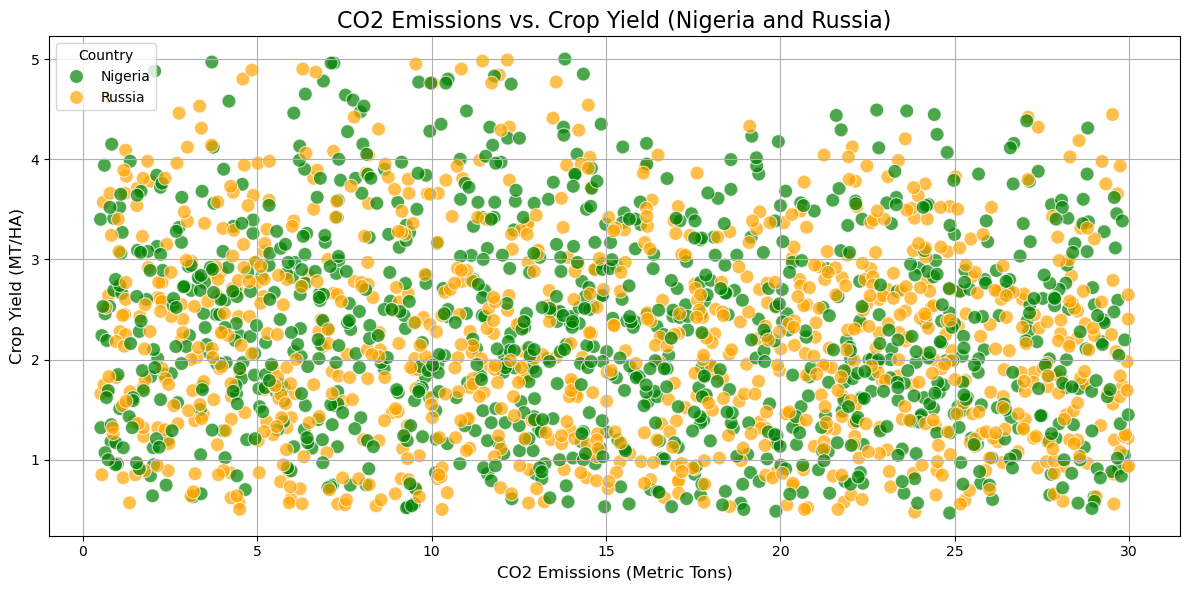

Correlations (CO2 Emissions vs. Crop Yield):
Nigeria: -0.10
Russia: -0.09


In [13]:
# Filter data for Nigeria and Russia
nigeria_russia_data = data[data["Country"].isin(["Nigeria", "Russia"])]

# Scatter plot: CO2 Emissions vs. Crop Yield for Nigeria and Russia
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=nigeria_russia_data,
    x="CO2_Emissions_MT",
    y="Crop_Yield_MT_per_HA",
    hue="Country",
    palette={"Nigeria": "green", "Russia": "orange"},
    s=100,
    alpha=0.7
)
plt.title("CO2 Emissions vs. Crop Yield (Nigeria and Russia)", fontsize=16)
plt.xlabel("CO2 Emissions (Metric Tons)", fontsize=12)
plt.ylabel("Crop Yield (MT/HA)", fontsize=12)
plt.grid()
plt.legend(title="Country", loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

# Calculate correlation for each country using Pandas
correlations = {}
for country in ["Nigeria", "Russia"]:
    country_data = nigeria_russia_data[nigeria_russia_data["Country"] == country]
    correlations[country] = country_data["CO2_Emissions_MT"].corr(country_data["Crop_Yield_MT_per_HA"])

# Print correlations
print("Correlations (CO2 Emissions vs. Crop Yield):")
for country, corr in correlations.items():
    print(f"{country}: {corr:.2f}")


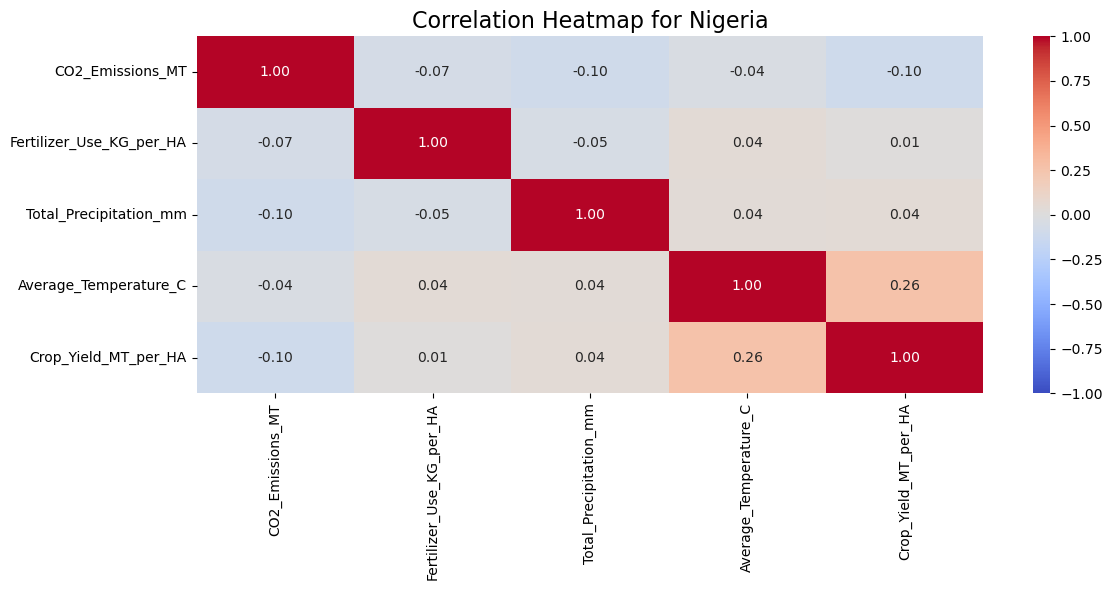

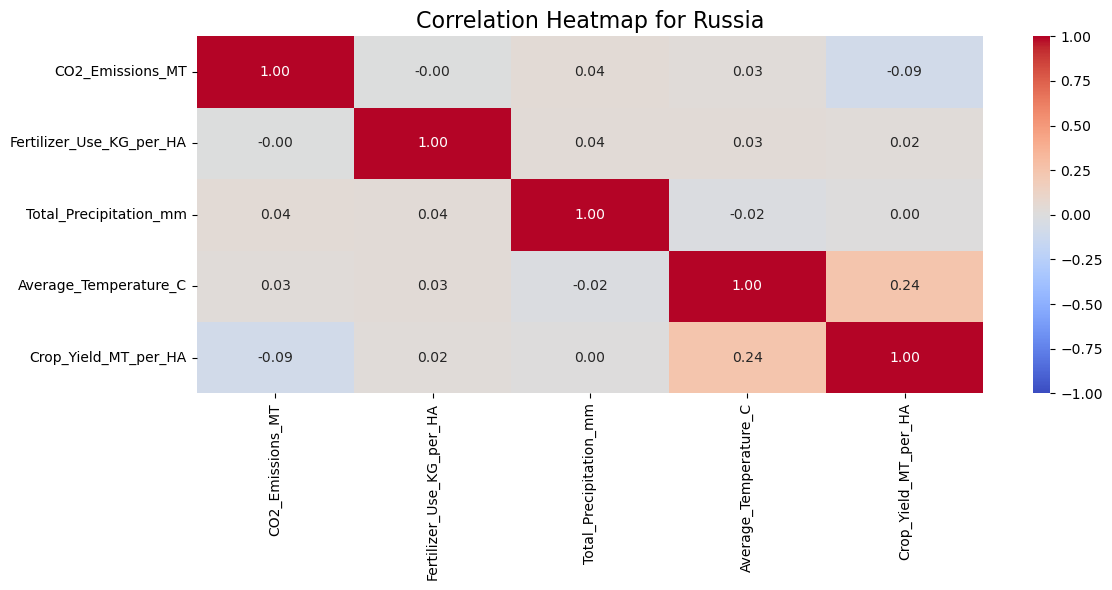

In [16]:
# Filter data for Nigeria and Russia
nigeria_data = nigeria_russia_data[nigeria_russia_data['Country'] == 'Nigeria']
russia_data = nigeria_russia_data[nigeria_russia_data['Country'] == 'Russia']

# Compute the correlation matrices
nigeria_corr_matrix = nigeria_data[['CO2_Emissions_MT', 'Fertilizer_Use_KG_per_HA', 
                                    'Total_Precipitation_mm', 'Average_Temperature_C', 
                                    'Crop_Yield_MT_per_HA']].corr()

russia_corr_matrix = russia_data[['CO2_Emissions_MT', 'Fertilizer_Use_KG_per_HA', 
                                  'Total_Precipitation_mm', 'Average_Temperature_C', 
                                  'Crop_Yield_MT_per_HA']].corr()

# Plot Nigeria correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(nigeria_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap for Nigeria", fontsize=16)
plt.tight_layout()
plt.show()

# Plot Russia correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(russia_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap for Russia", fontsize=16)
plt.tight_layout()
plt.show()
